<hr>

## Detection vs Recognition vs Tracking
<hr>

- 차이점
    - 검출(Detection): 영상에서 찾고자 하는 대상의 위치와 크기를 알아내는 작업
    - 인식(Recognition): 주어진 영상(객체)이 무엇인지 판별하는 작업(Classification, Identification)
    - 추적(Tracking): 동영상에서 이전 프레임에 있던 특정 대상의 현재 프레임에서의 위치 변화를 알아내는 작업
        - e.g., Mean Shift, CamShift, Optical flow, Trackers in OpenCV 3.x
    - 만약 사람의 얼굴이 포함된 영상에서 누구인지는 상관없이 `모든 얼굴을 찾는 것을 검출`, 그 중 `특정 인물을 찾는 것을 인식`,<br> 동영상이나 여러 장의 영상에서 `특정 대상의 변화를 찾는 것이 추적`이다.
- extra: Tracing vs Tracking
    - to Trace: 이미 주어진 경로(객체의 외곽선 등)의 자취를 쫒아가며 그 대상의 위치와 형태를 알아내는 작업
    - to Track: 동영상에서 특정 대상의 변화를 뒤쫒으며 추적하여 변화 과정을 알아내는 작업
    - 만약 철수가 `내 과자를 허락없이 먹은 것을 목격하여` 철수를 잡아 따지기 위해 철수의 뒤를 쫒아가는 것을 `Tracking`,<br>
    `누군가 내 과자를 허락없이 먹었는데` 주변에 과자 부스러기가 떨어져있고, 그 부스러기의 자취를 쫒아가봤더니 철수의 입가에<br>
    내 과자로 추정되는 과자 부스러기가 묻어 있는 것을 발견하여 철수에게 따지러 가는 것이 `Tracing`이다.

## <font color = "#CC3D3D">Case #1: Background Subtraction</font>

<hr>

### Step #1: Concept
<hr>

- 배경 차분(Background Subtraction: BS)
    - 등록된 배경 모델과 현재 입력 프레임과의 차영상을 이용하여 전경 객체를 검출하는 기법이다.
    - 움직이는 전경 객체 검출을 위한 기본적인 방법이다.
    - <img src="images/markdown/.png" width="600">

<hr>

### Step #2: Static Background Subtraction
<hr>

In [23]:
# 정적 배경을 이용한 전경 객체 검출 예제
import sys

import cv2

capture = cv2.VideoCapture("videos/PETS2000.avi")
# capture = cv2.VideoCapture("videos/vtest.avi")

if not capture.isOpened():
    print("Video open failed!")
    sys.exit()
else:
    print("Video open succeed!")

# 첫 번째 프레임을 배경 영상으로 등록
retval, background = capture.read()

if not retval:
    print("Background image registration failed!")
    sys.exit()
else:
    print("Background image registration succeed!")

# 컬러 값이 반드시 필요한 상황이 아니고, 연산 속도를 증가시키기 위해 그레이스케일로 변환
background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
background_gray = cv2.GaussianBlur(background_gray, (0, 0), 1)

# 비디오 매 프레임 처리
while True:
    retval, frame = capture.read()
    
    if not retval:
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.GaussianBlur(frame_gray, (0, 0), 1)
    
    # 차영상 구하기 & 이진화
    difference = cv2.absdiff(background_gray, frame_gray)
    _, difference = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)
    
    # 레이블링 기법을 이용하여 원본 프레임에 바운딩 박스 표시
    count, _, stats, _ = cv2.connectedComponentsWithStats(difference)
    
    for i in range(1, count):
        x, y, w, h, s = stats[i]
        
        if s < 100:
            continue
        
        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
    
    # OpenCV 가상 윈도우로 출력
    cv2.imshow("Frame", frame)
    cv2.imshow("Difference", difference)

    if cv2.waitKey(30) == 27:
        print("Video was interrupted!")
        break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Video open succeed!
Background image registration succeed!


-1

<hr>

### Step #3: Moving Average Background Subtraction
<hr>

- 정적 배경 모델 사용 시 문제점
    - 미리 등록된 디준 영상이 실제 배경과 크게 달라질 경우 오동작을 일으킬 수 있다.
        - e.g., 그림자 등의 영향으로 인한 `조도 변경`, 시점 변경으로 인한 `밝기 감소`, `새로운 객체가 화면에 고정`되는 경우
        - <img src="images/markdown/.png" width="600">

<hr>

- 평균 연산에 의한 배경 영상 생성
    - 움직이는 객체가 존재하는 수백 장의 입력 영상으로부터 `평균 영상`을 구한다.
    - <img src="images/markdown/.png" width="600">
    - 다만 수백 장의 이전 프레임을 버퍼에 저장하려면 `대용량 메모리가 필요`하다.

<hr>

- 이동 평균(Moving Average)
    - 수백 장의 영상을 저장하는 대신 `매 프레임이 들어올 때마다 평균 영상을 갱신`한다.
    - 평균 연산에 비해 대용량 버퍼 메모리가 필요하지 않다.
    - 내부 연산은 `cv2.addWeighted()` 함수와 같은 `가중치 합`을 구하는 형태이며, 이전 프레임까지의 `배경 영상`과 `현재 프레임`의<br>
    `가중치 합`을 계산하여 현재 프레임에서의 `배경 영상`을 업데이트 하는 방법이다.

$$B(x,y,t)=\alpha\cdot I(x,y,t)+(1-\alpha)\cdot B(x,y,t-1)$$
$$B(x,y,t)={\scriptstyle\text{갱신된 배경 영상}}$$
$$\alpha={\scriptstyle\text{현재 프레임에 대한 가중치}},\ (0<\alpha<1)$$
$$I(x,y,t)={\scriptstyle\text{현재 프레임}}$$
$$B(x,y,t-1)={\scriptstyle\text{이전 프레임까지의 배경 영상}}$$

<hr>

### Step #3-1: OpenCV function
<hr>

> `이동 평균 계산을 위한 가중치 누적 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}accumulateWeighted}(src, dst, alpha, mask)\rightarrow }$$
- src: 입력 영상
- dst: 축적 영상(결과 영상)
- alpha: (입력 영상에 대한) 가중치
- mask: 마스크 연산 시 사용할 마스크 영상
- `참고사항:`
    - src: 1 or 3 channel, 8 bit or 32 bit float type
    - dst: src와 동일 채널, 32 bit or 64 bit float type
    - alpha: `1을 지정`하면 이전까지의 배경 영상을 무시하고 `현재 프레임을 배경 영상으로 사용`한다.<br>
    반대로 `0을 지정`하면 현재 프레임에 대한 정보가 사라지고 처음에 모델로 사용한 배경 영상을 계속 사용한다.`(정적 배경 모델)`
        - 일반적으로 `0에 가까운 값`을 지정한다.`(e.g., alpha = 0.01 or less)`

<hr>

### Step #3-2: Implementation example
<hr>

In [22]:
# 이동 평균에 의한 배경 차분 예제
import sys

import cv2
import numpy as np

capture = cv2.VideoCapture("videos/PETS2000.avi")
# capture = cv2.VideoCapture("videos/vtest.avi")

if not capture.isOpened():
    print("Video open failed!")
    sys.exit()
else:
    print("Video open succeed!")

# 첫 번째 프레임을 배경 영상으로 등록
retval, background = capture.read()

if not retval:
    print("Background image registration failed!")
    sys.exit()
else:
    print("Background image registration succeed!")

# background: uint8 배경, background_float: float32 배경
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
background = cv2.GaussianBlur(background, (0, 0), 1)
background_float = background.astype(np.float32)

# 비디오 매 프레임 처리
while True:
    retval, frame = capture.read()
    
    if not retval:
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.GaussianBlur(frame_gray, (0, 0), 1)
    
    # background_float: 이전 프레임까지의 배경(float32), background: 갱신된 배경(uint8)
    cv2.accumulateWeighted(frame_gray, background_float, 0.01)
    background = background_float.astype(np.uint8)
        
    # 차영상 구하기 & 이진화
    difference = cv2.absdiff(background, frame_gray)
    _, difference = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)
    
    # 레이블링 기법을 이용한 원본 프레임의 움직이는 객체에 바운딩 박스 표시
    count, _, stats, _ = cv2.connectedComponentsWithStats(difference)
    
    for i in range(1, count):
        x, y, w, h, s = stats[i]
        
        if s < 100:
            continue
        
        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
    
    # OpenCV 가상 윈도우로 출력
    cv2.imshow("Frame", frame)
    cv2.imshow("Difference", difference)
    cv2.imshow("Background", background)

    if cv2.waitKey(30) == 27:
        print("Video was interrupted!")
        break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Video open succeed!
Background image registration succeed!


-1

<hr>

### Step #4: MOG Background Model
<hr>

- MOG
    - Mixture of Gaussian, GMM(Gaussian Mixture Model)
    - 각 픽셀에 대해 MOG 확률 모델을 설정하여 배경과 전경을 구분하는 일종의 데이터 분석 기법이다.

<hr>

- 다양한 배경 모델 구성 방법
    - <img src="images/markdown/.png" width="600">

<hr>

- dfdfdfd
    - <img src="images/markdown/.png" width="600">

<hr>

- dfdfdf
    - <img src="images/markdown/.png" width="600">

<hr>

### Step #4-1: OpenCV function
<hr>

> `배경 차분 알고리즘 객체 생성`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}createBackgroundSubtractorMOG2}(, history, varThreshold, detectShadows)\rightarrow retval}$$
- history: 히스토리 길이
- varThreshold: variance threshold. 픽셀과 모델 사이의 마할라노비스 거리(Mahalanobis distance) 제곱에 대한 임계값
- detectShadows: 그림자 검출 여부
- retval: cv2.BackgroundSubtractor 클래스 인스턴스(객체)
- `참고사항:`
    - history: 이전(과거) 프레임을 몇 개까지 사용할지를 지정한다.
        - `기본값은 500`
    - varThreshold: 해당 픽셀이 배경 모델에 의해 잘 표현되는 지를 판단한다. 이 파라미터는 배경 영상 갱신에 영향을 주지 않는다.
        - `기본값은 16`
    - detectShadows: `기본값은 True`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}createBackgroundSubtractorKNN}(, history, dist2Threshold, detectShadows)\rightarrow }$$
- history: 
- dist2Threshold: distance to threshold. 픽셀과 샘플 사이의 거리 제곱에 대한 임계값
- detectShadows: 
- retval: cv2.BackgroundSubtractor 클래스 인스턴스(객체)
- `참고사항:`
    - history: 이전(과거) 프레임을 몇 개까지 사용할지를 지정한다.
        - `기본값은 500`
    - dist2Threshold: 해당 픽셀이 샘플에 가까운 지를 판단한다. 이 파라미터는 배경 영상 갱신에 영향을 주지 않는다.
        - `기본값은 400`
    - detectShadows: `기본값은 True`

<hr>

> `전경 객체 마스크 생성 함수`

$$\mathsf{{\color{RoyalBlue}cv2.BackgroundSubtractor.}{\color{Tan}apply}(image, fgmask, learningRate)\rightarrow fgmask}$$
- image: (입력) 다음 비디로 프레임
- fgmask: foreground mask. (출력) 전경 마스크 영상
- learningRate: 배경 모델 학습율(속도) 지정
- `참고사항:`
    - fgmask: 8 bit 이진 영상(0 or 255). `detectShadows = True`이면 `0 or 128 or 255`로 이루어진 영상을 반환한다.
    - learningRate: 0 ~ 1 사이의 실수를 지정한다. `이동 평균의 가중치(alpha)`와 같은 역할이다.
        - 0: 배경 모델을 갱신하지 않음
        - 1: 매 프레임마다 배경 모델을 새로 만듦
        - -1: 자동으로 결정됨. `기본값`

<hr>

> `배경 영상 반환 함수`

$$\mathsf{{\color{RoyalBlue}cv2.BackgroundSubtractor.}{\color{Tan}getBackgroundImage}(, backgroundImage)\rightarrow backgroundImage}$$
- backgroundImage: (출력) 학습된 배경 영상

In [ ]:
import cv2
help(cv2.BackgroundSubtractor)

In [ ]:
import cv2
help(cv2.createBackgroundSubtractorMOG2)

In [ ]:
import cv2
help(cv2.createBackgroundSubtractorKNN)

In [ ]:
import cv2
help(cv2.BackgroundSubtractor.apply)

In [ ]:
import cv2
help(cv2.BackgroundSubtractor.getBackgroundImage)

<hr>

### Step #4-2: Implementation example
<hr>

In [18]:
# MOG 기법을 이용한 배경 생성 및 전경 객체 검출 예제
import sys

import cv2
import numpy as np

capture = cv2.VideoCapture("videos/PETS2000.avi")
# capture = cv2.VideoCapture("videos/vtest.avi")

if not capture.isOpened():
    print("Video open failed!")
    sys.exit()
else:
    print("Video open succeed!")

# 배경 차분 알고리즘 객체 생성
# BS = cv2.createBackgroundSubtractorMOG2()
BS = cv2.createBackgroundSubtractorKNN()

# 비디오 매 프레임 처리
while True:
    retval, frame = capture.read()
    
    if not retval:
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    fgmask = BS.apply(frame_gray)
    background = BS.getBackgroundImage()
    
    # 레이블링 기법을 이용하여 바운딩 박스 표시
    count, _, stats, _ = cv2.connectedComponentsWithStats(fgmask)
    
    for i in range(1, count):
        x, y, w, h, s = stats[i]
        
        if s < 100:
            continue
        
        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
    
    cv2.imshow("Frame", frame)
    cv2.imshow("Difference", fgmask)
    cv2.imshow("Background", background)
    
    if cv2.waitKey(30) == 27:
        print("Video was interrupted!")
        break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Video open succeed!


-1

## <font color = "#CC3D3D">Case #2: Mean Shift Algorithm</font>

<hr>

### Step #1: Concept
<hr>

- 평균 이동(Mean Shift)
    - 평균 이동이라고 하는 것은 데이터사이언스 분야에서 `어떤 데이터의 분포를 분석하는 기법 중 하나`이고, 어떤 데이터의 분포에서<br>
    `데이터가 가장 밀집되어 있는 부분`을 찾아내기 위한 기법이다.
        - e.g., 어떤 데이터가 가우시안 분포 형태를 이루고 있을 때 그 `가우시안 분포의 평균(mode)`를 찾아내는 방법이다.<br>
        경우에 따라서 `모드 검출(mode seeking) 알고리즘`이라는 용어로도 사용한다.
    - 평균 이동 알고리즘은 국지적 평균(Local Mean)을 탐색하면서 이동한다.

<hr>

- 평균 이동 알고리즘 작동 예시
    - <img src="images/markdown/MeanShifted.png" width="200">

<hr>

- 평균 이동 알고리즘의 단점
    - <img src="images/markdown/.png" width="600">

<hr>

### Step #2: OpenCV function
<hr>

> `평균 이동 알고리즘을 이용한 트래킹 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}meanShift}(probImage, window, criteria)\rightarrow retval}$$
- probImage: probabillity image. 입력 확률 영상
- window: `(x, y, w, h)` 형태의 튜플
- criteria: 알고리즘 종료 기준으로 `(type, maxCount, epsilon)` 형태의 튜플
- retval: 알고리즘 내부 반복 횟수
- `참고사항:`
    - probImage: 일반적으로 관심 객체에 대한 `히스토그램 역투영 결과 영상`을 지정한다.
    - window: 초기에 검색할 영역의 윈도우 위치와 크기를 지정한다. 보통 `입력으로 지정`하여 `업데이트된 결과를 출력으로 다시 반환` 받고,<br>
    그 결과를 `다시 입력으로 지정`하는 방법으로 사용한다.
    - criteria: terminal criteria.
        - e.g., `term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)`
            - 최대 10번 반복하며, 정확도가 1 이하이면(즉, x 또는 y 방향으로의 이동 크기가 1픽셀보다 작으면) 종료한다.


<hr>

### Step #3: Implementation example
<hr>

In [16]:
# 평균 이동 객체 추적 예제
import sys

import cv2


video = cv2.VideoCapture("videos/camshift.avi")

if not video.isOpened():
    print("Video open failed!")
    sys.exit()
else:
    print("Video open succeed!")

# 초기 사각형 영역 설정 - 여기선 사용자 지정값을 사용했지만 ROISelector 또는 객체 검출 기법중에 하나로 위치와 크기 정보를 얻을수도 있다.
x, y, w, h = 135, 220, 100, 100
window = (x, y, w, h)

retval, frame = video.read()

if not retval:
    print("frame read failed!")
    sys.exit()
else:
    print("frame read succeed!")

ROI = frame[y:y+h, x:x+w]
ROI_HSV = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)

# HSV 색공간 중 H, S에 대해서만 히스토그램 계산 - 밝기에 대한 변화에 강인하게 하기위해 V 평면은 히스토그램 계산에서 제외한다.
channels = [0, 1]
ranges = [0, 180, 0, 256]
histogram = cv2.calcHist([ROI_HSV], channels, None, [90, 128], ranges)

# Mean Shift 알고리즘 종료 기준 설정
TERM_CRIT = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

# 비디오 매 프레임 처리
while True:
    retval, frame = video.read()
    
    if not retval:
        break
    
    # H, S 히스토그램에 대한 역투영
    frame_HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    backproject = cv2.calcBackProject([frame_HSV], channels, histogram, ranges, 1)
    
    # Mean Shift
    _, window = cv2.meanShift(backproject, window, TERM_CRIT)
    
    # 추적 결과 출력
    cv2.rectangle(frame, window, (0, 0, 255), 2)
    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(60) == 27:
        print("Video was interrupted!")
        break

video.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

#### NOTE: 추적 대상(귤)을 놓치지 않고 잘 추적하지만 동영상에서 대상이 멀어지게(작게) 되어도 window의 크기가 100 x 100 크기를
#### 유지한 채로 추적한다. 반대로 대상이 가까워져도(크게) window의 크기는 그대로여서 대상을 온전히 표현하지 못 한다는 단점이 있다.
#### 이를 개선하기 위해선 추적 대상의 크기에 따라 window의 크기도 함께 변할 필요가 있다.

Video open succeed!
frame read succeed!


-1

## <font color = "#CC3D3D">Case #3: CamShift Algorithm</font>

<hr>

### Step #1: Concept
<hr>

- 캠시프트(CamShift)
    - 연속 적응 평균 이동(Continuously Adaptive Mean Shift)의 약자이다.
    - 추적하는 객체의 크기가 변하더라도 검색 윈도우의 크기가 고정되어 있는 평균 이동 알고리즘의 단점을 보완했다.

<hr>

- 캠시프트 동작 방법
    - 먼저 `평균 이동 알고리즘`으로 이동 위치를 계산한다.
    - `윈도우의 크기`를 조정한다.
    - 특징 공간을 가장 잘 표현하는 `타원을 검출`한다.
    - `새로운 크기의 윈도우`를 이용하여 다시 평균 이동을 수행한다.
    - <img src="images/markdown/Camshift.png" width="200">

<hr>

- 평균 이동 알고리즘의 단점 개선
    - <img src="images/markdown/.png" width="600">

<hr>

### Step #2: OpenCV function
<hr>

> `캠시프트 추적 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}CamShift}(probImage, window, criteria)\rightarrow retval, window}$$
- probImage: probabillity image. 입력 확률 영상
- window: `(x, y, w, h)` 형태의 튜플
- criteria: 알고리즘 종료 기준으로 `(type, maxCount, epsilon)` 형태의 튜플
- retval: `((cx, cy), (width, height), angle)` 형태의 튜플을 반환
- `참고사항:`
    - probImage: 일반적으로 관심 객체에 대한 `히스토그램 역투영 결과 영상`을 지정한다.
    - window: 초기에 검색할 영역의 윈도우 위치와 크기를 지정한다. 보통 `입력으로 지정`하여 `업데이트된 결과를 출력으로 다시 반환` 받고,<br>
    그 결과를 `다시 입력으로 지정`하는 방법으로 사용한다.
    - criteria: terminal criteria.
        - e.g., `term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)`
            - 최대 10번 반복하며, 정확도가 1 이하이면(즉, x 또는 y 방향으로의 이동 크기가 1픽셀보다 작으면) 종료한다.
    - retval: 추적하는 객체의 모양을 나타내는 회전된 사각형 정보를 담고 있다.

<hr>

### Step #3: Implementation example
<hr>

In [55]:
# 캠시프트 알고리즘을 이용한 객체 추적
import sys

import cv2


video = cv2.VideoCapture("videos/camshift.avi")

if not video.isOpened():
    print("Video open failed!")
    sys.exit()
else:
    print("Video open succeed!")
    
# 초기 윈도우 영역 설정 - 여기선 사용자 지정값을 사용했지만 ROISelector 또는 객체 검출 기법중에 하나로 위치와 크기 정보를 얻을수도 있다.
x, y, w, h = 135, 220, 100, 100
window = (x, y, w, h)

retval, frame = video.read()

if not retval:
    print("frame read failed!")
    sys.exit()
else:
    print("frame read succeed!")

ROI = frame[y:y+h, x:x+w]
ROI_HSV = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)

# HSV 색공간 중 H, S에 대해서만 히스토그램 계산 - 밝기에 대한 변화에 강인하게 하기위해 V 평면은 히스토그램 계산에서 제외한다.
chennels = [0, 1]
ranges = [0, 180, 0, 256]
histogram = cv2.calcHist([ROI_HSV], channels, None, [90, 128], ranges)
cv2.imshow("histogram", histogram)

# Mean Shift 알고리즘 종료 기준 설정
TERM_CRIT = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

# 비디오 매 프레임 처리
while True:
    retval, frame = video.read()
    
    if not retval:
        break
    
    # H, S 히스토그램에 대한 역투영
    frame_HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    backproject = cv2.calcBackProject([frame_HSV], channels, histogram, ranges, 1)
    
    # CamShift
    rotated_rec, window = cv2.CamShift(backproject, window, TERM_CRIT)
    
    # 추적 결과 출력
    cv2.rectangle(frame, window, (0, 0, 255), 2)
    cv2.ellipse(frame, rotated_rec, (0, 255, 0), 2)
    cv2.imshow("Frame", frame)
    cv2.imshow("backproject", backproject)
    
    if cv2.waitKey(60) == 27:
        print("Video was interrupted!")
        break
    
video.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Video open succeed!
frame read succeed!


-1

## <font color = "#CC3D3D">Case #4: Optical flow</font>

<hr>

### Step #1: Concept
<hr>

- 옵티컬플로우(Optical flow)
    - 연속하는 두 프레임(영상)에서 카메라 또는 객체의 움직임에 의해 나타나는 객체의 이동 정보 패턴을 추출하는 기법이다.
    - <img src="images/markdown/.png" width="600">

<hr>

- 옵티컬플로우 활용 분야
    - Structure from Motion: 영상 속 3차원 구조체의 모양 정보 판단
    - Video Compression: 고효율 동영상 압축
    - Video Stabilization: 손떨림 방지
    - etc.

<hr>

### Step #2: Method
<hr>

- 옵티컬플로우 계산
    - 밝기 불변성(Brightness constancy constraint)
    - 가정: 이웃 픽셀은 같은 Flow를 가진다. -> N x N 크기의 window를 사용하면 N²개의 방정식이 세워짐
        -> 최소제곱법(Least squares method)을 통해 가장 적합한 Optical Flow(Vx: x방향으로의 속도, Vy: y방향으로의 속도)값을<br>
        계산할 수 있다.

$$
$$

<hr>

- OpenCV 옵티컬플로우 계산 함수
    - 루카스-카나데 알고리즘(Lucas-Kanade algorithm)
        - cv2.calcOpticalFlowPyrLK(...)
        - 주로 희소점(`Sparse` points)에 대한 이동 벡터를 계산하는 방법
            - 모든 점(픽셀)에 대해서 옵티컬플로우를 계산하지 않고, 사용자가 지정한 `몇몇 특정한 점들`에 대해서만 이 점들의 이동 정보를 반환한다.<br>
            여기서 Sparse points로 사용하는 점들은 주로 `corner points`이다. corner points는 앞서 배웠듯이 flat한 영역과 달리<br>
            변별력이 높다는 장점이 있다.
    - 파네백 알고리즘(Farneback's algorithm)
        - cv2.calcOpticalFlowFarneback(...)
        - (Dense points)에 대한 이동 벡터를 계산하는 방법
            - 모든 픽셀(점)에서 옵티컬플로우 벡터를 계산한다.

<hr>

### Step #3: OpenCV function
<hr>

> `루카스-카나데 옵티컬플로우 계산 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}calcOpticalFlowPyrLK}(prevImg, nextImg, prevPts, nextPts, status, err, winSize, maxLavel, criteria, flags, minEigThreshold)\rightarrow nextPts, status, err}$$
- prevImg: 이전 프레임 영상
- nextImg: 현재 프레임 영상
- prevPts: 이전 프레임에서 `추적할 점들`
- nextPts: prevPts 점들이 이동한 `현재 프레임에서의 좌표`(출력)
- status: 점들의 매칭 상태(출력)
- err: 결과의 오차 정보(출력)
- winSize: 각 피라미드 레벨에서 검색할 윈도우 크기
- maxLevel: 최대 피라미드 레벨
- criteria: (반복 알고리즘의) 종료 기준
- flags: 옵티컬플로우 연산 플래그
- minEigThreshold: `최소 고유값`의 임계점
- `참고사항:`
    - prevImg: 8 bit image
    - nextImg: 8 bit image
    - prevPts:
        - type=`numpy.ndarray`
        - shape=`(N, 1, 2)`
        - dtype=`numpy.float32`
    - nextPts: 보통 `None을 지정`하여 출력으로 받는다.
    - status: 0 또는 1의 1차원 이진 행렬이다. 만약 i번째 원소가 1이면 prevPts의 i번째 점이 nextPts의 i번째 점으로 이동한다.
        - type=`numpy.ndarray`
        - shape=`(N, 1)`
        - dtype=`(numpy.uint8)`
    - err:
        - type=`numpy.ndarray`
        - shape=`(N, 1)`
        - dtype=`numpy.float32`
    - window:
        - `기본값은 (21, 21)`
    - maxLevel: 0이면 피라미드를 사용하지 않는다.
        - `기본값은 3`
    - criteria: 
        - `기본값은 e.g., (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)`
    - flags:
        - cv2.OPTFLOW_USE_INITIAL_FLOW: `nextPts`에 저장된 초기 추정값을 사용한다.
        - cv2.OPTFLOW_LK_GET_MIN_EIGENVALS : 최소 고유값을 오차 측정값으로 사용한다.
        - `기본값은 0`
    - minEigThreshold: 루카스-카나데 알고리즘은 옵티컬플로우 방정식의 2x2 일반행렬의 최소 고유값을 창의 픽셀 수로 나눈 값을 계산한다.<br>
    만약 이 값이 minEigThreshold보다 작으면 해당 특징이 필터링되고 해당 흐름이 처리되지 않으므로 불량점을 제거하고 성능을 높일 수 있다.
        - `기본값은 0.0001(1e-4)`

In [ ]:
import cv2
help(cv2.calcOpticalFlowPyrLK)

<hr>

### Step #4: Sparse Optical Flow Implementation example
<hr>

In [17]:
# 루카스-카나데 옵티컬플로우 계산 예제
import sys

import cv2
import matplotlib.pyplot as plt


source1 = cv2.imread("images/frame1.jpg")
source2 = cv2.imread("images/frame2.jpg")

if source1 is None or source2 is None:
    print("Image load failed!")
    sys.exit()
else:
    print("Image load succeed!")

Image load succeed!


In [15]:
# 코너점 검출 - 이전 프레임(prevImg)으로 지정할 영상에서 추적할 점들을 검출한다.
source1_gray = cv2.cvtColor(source1, cv2.COLOR_BGR2GRAY)  # GFTT 알고리즘은 입력 영상으로 그레이스케일 영상을 받는다.
prev_points = cv2.goodFeaturesToTrack(source1_gray, 50, 0.01, 10)

# 루카스-카나데 옵티컬플로우 계산 - prevImg, nextImg 파라미터 전달값으로 그레이스케일 영상을 지정해도 왠만큼 잘 동작하지만
# 컬러 영상을 지정하는 것이 시간은 오래걸려도 좀 더 좋은 결과를 얻을 수도 있다.
next_points, status, error = cv2.calcOpticalFlowPyrLK(source1, source2, prev_points, None)

prev_points = prev_points.astype(np.uint32)
next_points = next_points.astype(np.uint32)

In [31]:
# 결과 영상 생성
destination = cv2.addWeighted(source1, 0.5, source2, 0.5, 0)

# 추적할 점과 이동한(계산된) 점 위치 표현
for i in range(next_points.shape[0]):
    if status[i, 0] == 0:
        print(i, next_points[i, 0], error[i, 0])
        continue
    
    destination = cv2.circle(destination, (prev_points[i, 0]), 4, (0, 255, 255), -1, cv2.LINE_AA)
    destination = cv2.circle(destination, (next_points[i, 0]), 4, (0, 0, 255), -1, cv2.LINE_AA)
    destination = cv2.arrowedLine(destination, (prev_points[i, 0]), (next_points[i, 0]), (0, 255, 0), 2, cv2.LINE_AA)

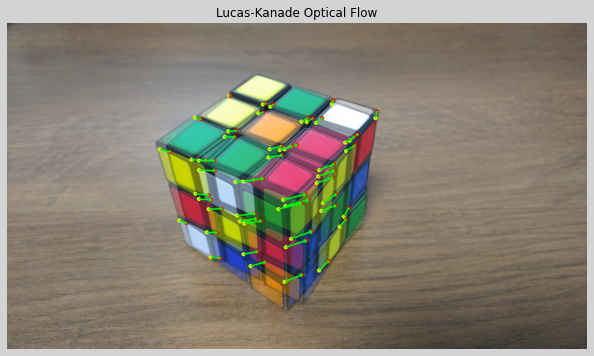

In [26]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")
plt.title("Lucas-Kanade Optical Flow")
plt.axis("off")
plt.imshow(destination[..., ::-1])
plt.show()

In [27]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Lucas-Kanade Optical Flow", destination)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [3]:
# 카메라 입력에 대한 옵티컬플로우 계산 예제
import sys
import numpy as np
import cv2


# 카메라 장치 열기
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

# 설정 변수 정의
MAX_COUNT = 50
needToInit = False
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
          (0, 255, 255), (255, 0, 255), (128, 255, 0), (0, 128, 128)]

ptSrc = None
ptDst = None

# 카메라 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    img = frame.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if needToInit:
        ptSrc = cv2.goodFeaturesToTrack(gray, 50, 0.01, 10)
        needToInit = False

    if ptSrc is not None:
        if prev is None:
            prev = gray.copy()

        ptDst, status, _ = cv2.calcOpticalFlowPyrLK(prev, gray, ptSrc, None)

        for i in range(ptDst.shape[0]):
            if status[i, 0] == 0:
                continue

            cv2.circle(img, tuple(ptDst[i, 0].astype(np.uint32)), 4, colors[i % 8], 2, cv2.LINE_AA)

    cv2.imshow('frame', img)
    key = cv2.waitKey(1)

    if key == 27:
        break
    elif key == ord('r'):
        needToInit = not needToInit
    elif key == ord('c'):
        ptSrc = None
        ptDst = None

    ptDst, ptSrc = ptSrc, ptDst
    prev = gray

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

<hr>

### Step #5: OpenCV function
<hr>

> `밀집 옵티컬플로우 계산 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}calcOpticalFlowFarneback}(prev, next, flow, pyr\_scale, levels, winsize, iterations, poly\_n, poly\_sigma, flags)\rightarrow flow}$$
- prev: 이전 프레임 영상
- next: 현재 프레임 영상
- flow: 계산된 옵티컬플로우 영상(출력)
- pyr_scale: 피라미드 영상을 만들 때의 축소 비율
- levels: 피라미드 영상 개수
- winsize: 평균 윈도우 크기
- iterations: 각 피라미드 레벨에서 알고리즘 반복 횟수
- poly_n: 다항식 확장을 위한 이웃 픽셀 크기
- poly_sigma: 가우시안 표준편차
- flags: 옵티컬플로우 연산 플래그
- `참고사항:`
    - prev: 8 bit single-channel(grayscale) image
    - flow: prev 영상과 동일한 크기이다. `x방향 모션벡터와 y방향 모션벡터`가 포함되어 있다.
        - type=`numpy.ndarray`
        - shape=`(h, w, 2)`
        - dtype=`numpy.float32`
    - pyr_scale: e.g., `0.5`
    - levels: e.g., `3`. 1을 지정하면 피라미드 영상을 만들지 않는다.
    - winsize: 보통 `13에서 15`를 지정한다. 값이 클수록 이미지 노이즈에 대한 강인함이 증가하고 빠른 움직임 감지에 대한<br>
    더 많은 기회가 제공되지만 더 흐릿한 모션 필드가 생성된다.
    - iterations: e.g., `10`
    - poly_n: 보통 `5 또는 7`을 지정한다.
    - poly_sigma: 보통 `poly_n = 5 이면 1.1`, `poly_n = 7 이면 1.5`를 지정한다.
    - flags: 0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN 중 `0을 사용`하면 무난하다.

In [ ]:
import cv2
help(cv2.calcOpticalFlowFarneback)

<hr>

### Step #6: Dense Optical Flow Implementation example
<hr>

In [32]:
# 진행 방향을 Hue 값으로 표현
def draw_flow_as_HUE(HSV, flow):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
    HSV[..., 0] = angle / 2
    HSV[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    BGR = cv2.cvtColor(HSV, cv2.COLOR_HSV2BGR)
    
    return BGR


# 진행 방향을 직선으로 표현
def draw_flow_as_line(next_image, flow, step=16):
    h, w = next_image.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    visualization = cv2.cvtColor(next_image, cv2.COLOR_GRAY2BGR)
    cv2.polylines(visualization, lines, False, (0, 255, 255), lineType=cv2.LINE_AA)

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(visualization, (x1, y1), 1, (0, 128, 255), -1, lineType=cv2.LINE_AA)

    return visualization

In [33]:
# 파네백 옵티컬플로우 계산 예제
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np


video = cv2.VideoCapture("videos/vtest.avi")

if video.isOpened():
    print("Video open succeed!")

retval, prev_frame = video.read()

if not retval:
    print("frame read failed!")

prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# prev_frame과 같은 크기 & 같은 타입의 0으로 초기화된 HSV 색 공간을 정의하고 S 평면을 255로 초기화
HSV = np.zeros_like(prev_frame)
HSV[..., 1] = 255  # Saturation = 255

# 매 프레임 처리
while True:
    retval, next_frame = video.read()
    
    if not retval:
        break
    
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, next_frame_gray, None, 0.5, 3, 13, 10, 5, 1.1, 0)
    
    cv2.imshow("frame", next_frame)
    
    # 진행 방향을 Hue 값으로 표현
    cv2.imshow("hue flow1", draw_flow_as_HUE(HSV, flow))
    
    # 진행 방향을 직선으로 표현
    cv2.imshow("line_flow", draw_flow_as_line(next_frame_gray, flow))
    
    if cv2.waitKey(30) == 27:
        print("Video was interrupted!")
        break
    
    prev_frame_gray = next_frame_gray

video.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Video open succeed!
Video was interrupted!


-1

## <font color = "#CC3D3D">Case #5: OpenCV Tracker</font>

<hr>

### Step #1: Concept
<hr>

- OpenCV 트래커(OpenCV Tracker)
    - dfdf

In [ ]:
$$\mathsf{{\color{RoyalBlue} }{\color{Tan} }()\rightarrow }$$
- <img src="images/markdown/.png" width="600">

<hr>

### Step #2: OpenCV function
<hr>

<hr>

### Step #3: Implementation example
<hr>